## SOUND-TYPES IMPROVEMENTS
#### *(draft)*

### Computing spectrograms from input signal
A *time-frequency* representation is desired in order to extract feature from a signal representation. Doing so, the **STFT** (*Short-time Fourier Transform*) is used in the computational efficient implementation of the *FFT*. 

In [74]:
import numpy as np
import librosa
audioFile = 'samples/Jarrett_Vienna_cut.wav'
[y, sr] = librosa.core.load(audioFile,sr=None, mono=True)

# get audiofile first 30 secs
len = sr * 10
y = y[0:len]

# get options for computing spectrogram
mels = 128 # frequency resolution
fft = 1024 # fft length
hop = 512  # hop size

# Mel spectrogram for the file, overlap=50%
S = librosa.feature.melspectrogram(y, sr, n_fft=fft, n_mels=mels, hop_length=hop)
# log-compressed version
S = librosa.power_to_db(S, ref=np.max)

# maybe adding dynamic range compression stage? (Dieleman, 2014)
# (C = amount of compression, set by heuristics)
# C = 10000
# S = np.log(1 + C*S)

# get spectrogram matrix dimensions (to be used in the convnet)
dims = S.shape

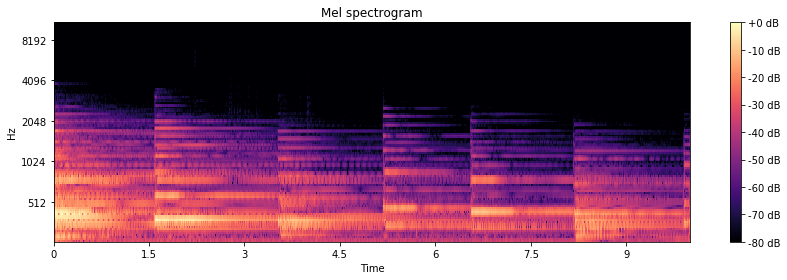

In [75]:
import matplotlib.pyplot as plt
import librosa.display

# plot the spectrogram
plt.figure(figsize=[12,4])
librosa.display.specshow(S, sr=sr, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

### Feature learning using deep learning
#### (Tensorflow implementation)
Convolutional layers can be implemented using the `tf.nn.conv2d`.
In this case 1-D convolutional filters should be implemented, in a sense that the convolutional filter spans over the time but not in the frequency dimensions. 

Following Dieleman's approach, the filter for the first convolutional layer will be of size 6 x *mels*, where *mels* is the number of frequency bins defined in the spectrogram. The dimension of the window in the *max pooling* process between each layer is *mels* x 4.

In [150]:
# interactive session for network building
import tensorflow as tf
sess = tf.InteractiveSession()

# for reproducibility
tf.set_random_seed(0)

# nodes for the input and output of the network graph
# obs: the use of [None, None] requires later specifications
x = tf.placeholder(tf.float32, shape=[None,None],name='spectrogram')
y_ = tf.placeholder(tf.float32, shape=[None, None],name='logits')

# weight and bias initialisation functions
# (with small amount of noise to prevent 0 gradient and with slightly positive bias to avoid dead neurons)
def Weight(shape):
    init = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init)

def Bias(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

# define convolution and pooling operations
def conv(x, W):
    stride = 1 # fixed stride all over the layers
    return tf.nn.conv2d(
        input=x, 
        filter=W, 
        strides=[1, stride, stride, 1], 
        padding='SAME'
    )

def maxPool(x, pool_size, pool_stride):
    return tf.nn.max_pool(
        x, 
        ksize=[1, 128, pool_size, 1],
        strides=[1, 128, pool_stride, 1], 
        padding='SAME')

# check for safety (dims and size of x must be the same)
print(dims)
print(x.get_shape().as_list())

(128, 862)
[None, None]


In [154]:
# First convolutional layer
# In this layer, the convolution will compute 256 feature for each patch.
# The patch is taking all the frequency bins and spanning 6 frames
W_conv1 = Weight([dims[0], 6, 1, 256]) # the filter patch should be 128 * 6
b_conv1 = Bias([1])

# reshape in 4D with the final dimension corresponding to the number of channels
# how to read: 1 spectrogram, spectogram dimensions, 1 channel of depth
x_ = tf.reshape(x, [1, dims[0], dims[1], 1])
print("Input dimensions:", x_.get_shape().as_list())

# conv layer linear function with ReLU activation
h_conv1 = tf.nn.relu(conv(x_, W_conv1) + b_conv1)
h_pool1 = maxPool(h_conv1, 4, 4)

# dimensions check
print("Convolutional layer dimensions:", h_conv1.get_shape().as_list())
print("After pooling:", h_pool1.get_shape().as_list())

Input dimensions: [1, 128, 862, 1]
Convolutional layer dimensions: [1, 128, 862, 256]
After pooling: [1, 1, 216, 256]


In [155]:
# Second convolutional layer
# In this layer, the convolution will compute 256 feature for each patch.
# The patch is taking all the frequency bins and spanning 6 frames
W_conv2 = Weight([dims[0], 6, 256, 256])
b_conv2 = Bias([1])

# conv layer linear function with ReLU activation
h_conv2 = tf.nn.relu(conv(h_pool1, W_conv2) + b_conv2)
h_pool2 = maxPool(h_conv2, 2, 2)

# dimensions check
print("Convolutional layer dimensions:", h_conv2.get_shape().as_list())
print("After pooling", h_pool2.get_shape().as_list())

Convolutional layer dimensions: [1, 1, 216, 256]
After pooling [1, 1, 108, 256]


In [120]:
# Third convolutional layer
# In this layer, the convolution will compute 512 feature for each patch.
# The patch is taking all the frequency bins and spanning 6 frames
W_conv3 = Weight([dims[0], 6, 256, 512])
b_conv3 = Bias([1])

# conv layer linear function with ReLU activation
h_conv3 = tf.nn.relu(conv(h_pool2, W_conv3) + b_conv2)

# dimensions check
print(h_conv3.get_shape().as_list())

[1, 1, 108, 512]


In [121]:
# Global temporal pooling
# This layer computes statistics pooling across the entire time axis using 3 different functions.

h_pool3_max = tf.nn.max_pool(h_conv3, ksize=[1, 1, 108, 1],strides=[1, 1, 108, 1], padding='SAME')
h_pool3_mean = tf.nn.avg_pool(h_conv3,ksize=[1, 1, 108, 1],strides=[1, 1, 108, 1], padding='SAME')
#h_pool3_L2 = tf.sqrt(tf.nn.avg_pool(tf.square(h_conv3), ksize=[1, 1, 108, 1],strides=[1, 1, 108, 1], padding='SAME')

In [122]:
# some output for check
print(h_pool3_max.get_shape().as_list())
print(h_pool3_mean.get_shape().as_list())

[1, 1, 1, 512]
[1, 1, 1, 512]


In [123]:
# stack the two pooling layers
h_poolMain = tf.concat([h_pool3_max, h_pool3_mean], axis=1)
print(h_poolMain.get_shape().as_list())

# reshape in one long array
h_poolMain = tf.reshape(h_poolMain,[-1,2*512])
print(h_poolMain.get_shape().as_list())

[1, 2, 1, 512]
[1, 1024]


In [124]:
# Densely connected layers
# This is a series of fully-connected layer with 2048 rectified linear units.

# Layer no. 1
# set up weights and biases
W_fc1 = Weight([1024, 2048])
b_fc1 = Bias([2048])

# linear function for the fully-connected layer
h_fc1 = tf.nn.relu(tf.matmul(h_poolMain, W_fc1) + b_fc1)
print(h_fc1.get_shape().as_list())

# Layer no. 2
# set up weights and biases
W_fc2 = Weight([2048, 2048])
b_fc2 = Bias([2048])

# rescaling and linear function for the fully-connected layer
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
print(h_fc2.get_shape().as_list())

[1, 2048]
[1, 2048]


In [125]:
# Dropout stage before the readout layer
dropout_prob = tf.placeholder(tf.float32)
h_fc2_drop = tf.nn.dropout(h_fc2, dropout_prob)

In [114]:
# Readout layer
# This is the final fully-connected layer with the softmax to create a vector of probabilities
W_out = Weight([2048, 10])
b_out = Bias([10])

y_ = tf.matmul(h_fc2_drop, W_out) + b_out

# logits dimensions check
print(y_.get_shape().as_list())

[1, 10]
